In [46]:
import torch_geometric
print(torch_geometric.__version__)
import torch
print(torch.__version__)
import pickle
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GraphConv, SAGEConv
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import pandas as pd
import scipy.sparse as sp
import torch
from torch_geometric.loader import NeighborLoader
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, HeteroConv, GraphConv, HGTConv, Linear
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, auc
from torch.utils.data import random_split
from torch_geometric.data import HeteroData
import warnings
import math
import random
import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

2.7.0
2.4.1


In [47]:
def seed_everything(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

seed_everything(42)

Random seed set as 42


In [48]:
# config = dict()
# config["lr"] = 0.001
# config["weight_decay"] = 5e-3
# config["epochs"] = 20
# config['train_ratio'] = 0.8
# config['val_ratio'] = 0.1
# config['test_ratio'] = 0.1
# config['hidden_channels'] = 64
# config['num_heads'] = 4
# config['num_layers'] = 2
# config

In [49]:
file = '../data/final_data_dict.pkl'
with open(file, 'rb') as f:
    data = pickle.load(f)

In [50]:
# def make_edges_undirected(edge_index):
#     reverse_edge_index = edge_index.flip([0])
#     undirected_edge_index = torch.cat([edge_index, reverse_edge_index], dim=1)
#     return torch.unique(undirected_edge_index, dim=1)

# def make_graph_edges_undirected(edge_index_dict):
#     undirected_edge_index_dict = {}
#     for edge_type, edge_index in edge_index_dict.items():
#         undirected_edge_index_dict[edge_type] = make_edges_undirected(edge_index)
#     return undirected_edge_index_dict

def generate_negative_pairs(num_diseases, num_drugs, full_pos_edge_index, exclude_disease=1446, num_neg_samples=None):
    positive_set = set((disease.item(), drug.item()) for disease, drug in zip(full_pos_edge_index[0], full_pos_edge_index[1]))
    all_possible_pairs = [(disease, drug) for disease in range(num_diseases)
                          if disease != exclude_disease  # Exclude disease 1446
                          for drug in range(num_drugs)]
    negative_candidates = [(disease, drug) for disease, drug in all_possible_pairs if (disease, drug) not in positive_set]
    if num_neg_samples is None:
        num_neg_samples = len(full_pos_edge_index[0])
    neg_pairs = random.sample(negative_candidates, num_neg_samples)
    neg_pairs = torch.tensor(neg_pairs, dtype=torch.long).t()
    return neg_pairs

In [51]:
def train_test_split_edges(pos_edges, test_size=0.2):
    pos_edges_np = pos_edges.cpu().numpy().T
    train_edges_np, test_edges_np = train_test_split(pos_edges_np, test_size=test_size)
    train_edges = torch.tensor(train_edges_np).T.to(pos_edges.device)
    test_edges = torch.tensor(test_edges_np).T.to(pos_edges.device)
    return train_edges, test_edges

def create_pyg_heterograph_with_splits(data, test_size=0.2):
    
    graph = HeteroData()

    # Add features
    drug_feat = torch.tensor(data['d_feat'], dtype=torch.float32)
    disease_feat = torch.tensor(data['dis_feat'], dtype=torch.float32)
    protein_feat = torch.tensor(data['p_feat'], dtype=torch.float32)
    if drug_feat.is_sparse:
        drug_feat = drug_feat.to_dense()
    if disease_feat.is_sparse:
        disease_feat = disease_feat.to_dense()
    if protein_feat.is_sparse:
        protein_feat = protein_feat.to_dense()
    graph['drug'].x = drug_feat
    graph['disease'].x = disease_feat
    graph['protein'].x = protein_feat

    pos_edges = torch.stack([
        torch.tensor(data['dd_adj'].row, dtype=torch.long),
        torch.tensor(data['dd_adj'].col, dtype=torch.long)
    ])
    
    train_pos_edges, test_pos_edges = train_test_split_edges(pos_edges, test_size)
    graph['disease', 'interacts', 'drug'].train_pos_edge_index = train_pos_edges
    graph['disease', 'interacts', 'drug'].test_pos_edge_index = test_pos_edges

    full_pos_edge_index = torch.cat([train_pos_edges, test_pos_edges], dim=1)
    graph['disease', 'interacts', 'drug'].edge_index = full_pos_edge_index

    edge_index_dict = {
        ('drug', 'interacts', 'protein'): torch.stack([
            torch.tensor(data['dp_adj'].row, dtype=torch.long),
            torch.tensor(data['dp_adj'].col, dtype=torch.long)
        ]),
        ('disease', 'interacts', 'protein'): torch.stack([
            torch.tensor(data['disp_adj'].row, dtype=torch.long),
            torch.tensor(data['disp_adj'].col, dtype=torch.long)
        ]),
        ('protein', 'interacts', 'protein'): torch.stack([
            torch.tensor(data['pp_adj'].row, dtype=torch.long),
            torch.tensor(data['pp_adj'].col, dtype=torch.long)
        ]),
    }

    graph = T.ToUndirected()(graph)

    # undirected_edge_index_dict = make_graph_edges_undirected(edge_index_dict)

    # for edge_type, undirected_edge_index in undirected_edge_index_dict.items():
    #     graph[edge_type].edge_index = undirected_edge_index

    return graph

In [52]:
class HGT(torch.nn.Module):
    def __init__(self, graph, hidden_channels, out_channels, num_heads, num_layers, num_dis, num_drug, num_prot):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        self.lin_dict["disease"] = Linear(num_dis, hidden_channels)
        self.lin_dict["drug"] = Linear(num_drug, hidden_channels)
        self.lin_dict["protein"] = Linear(num_prot, hidden_channels)
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, graph.metadata(), num_heads)
            self.convs.append(conv)

    def forward(self, x_dict, edge_index_dict):
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x).relu_()
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
        return x_dict

def train_hetero_gnn(graph, model, optimizer, device, num_epochs=100):

    loss_curve = []
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(graph.x_dict, graph.edge_index_dict)
        pos_edges = graph['disease', 'interacts', 'drug'].train_pos_edge_index
        num_diseases = graph['disease'].x.size(0)
        num_drugs = graph['drug'].x.size(0)
        full_pos_edge_index = graph['disease', 'interacts', 'drug'].edge_index
        neg_edges = generate_negative_pairs(num_diseases, num_drugs, full_pos_edge_index, exclude_disease=1446, num_neg_samples=len(pos_edges[0]))
        pos_score = (out['drug'][pos_edges[1]] * out['disease'][pos_edges[0]]).sum(dim=1)
        neg_score = (out['drug'][neg_edges[1]] * out['disease'][neg_edges[0]]).sum(dim=1)
        loss = torch.mean(F.softplus(neg_score - pos_score))
        loss.backward()
        optimizer.step()
        loss_curve.append(loss.item())
        
        if((epoch%5)==0):
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

    return loss_curve

def evaluate_model(graph, model, device):
    model.eval()
    with torch.no_grad():
        out = model(graph.x_dict, graph.edge_index_dict)
        num_diseases = graph['disease'].x.size(0)
        num_drugs = graph['drug'].x.size(0)

        pos_edges = graph['disease', 'interacts', 'drug'].train_pos_edge_index
        full_pos_edge_index = graph['disease', 'interacts', 'drug'].edge_index
        neg_edges = generate_negative_pairs(num_diseases, num_drugs, full_pos_edge_index, exclude_disease=1446, num_neg_samples=len(pos_edges[0]))
        pos_score = (out['drug'][pos_edges[1]] * out['disease'][pos_edges[0]]).sum(dim=1).sigmoid()
        neg_score = (out['drug'][neg_edges[1]] * out['disease'][neg_edges[0]]).sum(dim=1).sigmoid()
        scores = torch.cat([pos_score, neg_score]).cpu().numpy()
        labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))]).cpu().numpy()
        auc = roc_auc_score(labels, scores)
        f1 = f1_score(labels, (scores > 0.5).astype(int))
        precision = precision_score(labels, (scores > 0.5).astype(int))
        recall = recall_score(labels, (scores > 0.5).astype(int))
        print(f"Train AUC: {auc}, F1: {f1}, Precision: {precision}, Recall: {recall}")

        pos_edges = graph['disease', 'interacts', 'drug'].test_pos_edge_index
        full_pos_edge_index = graph['disease', 'interacts', 'drug'].edge_index
        neg_edges = generate_negative_pairs(num_diseases, num_drugs, full_pos_edge_index, exclude_disease=1446, num_neg_samples=len(pos_edges[0]))
        pos_score = (out['drug'][pos_edges[1]] * out['disease'][pos_edges[0]]).sum(dim=1).sigmoid()
        neg_score = (out['drug'][neg_edges[1]] * out['disease'][neg_edges[0]]).sum(dim=1).sigmoid()
        scores = torch.cat([pos_score, neg_score]).cpu().numpy()
        labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))]).cpu().numpy()
        auc = roc_auc_score(labels, scores)
        f1 = f1_score(labels, (scores > 0.5).astype(int))
        precision = precision_score(labels, (scores > 0.5).astype(int))
        recall = recall_score(labels, (scores > 0.5).astype(int))
        print(f"Test AUC: {auc}, F1: {f1}, Precision: {precision}, Recall: {recall}")

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph = create_pyg_heterograph_with_splits(data, 0.2)

hidden_channels = 32
out_channels = 16
num_heads = 4
num_layers = 2
epochs = 10

n_drug = data['n_drug']
n_prot = data['n_prot']
n_dis = data['n_dis']

model = HGT(graph, hidden_channels, out_channels, num_heads, num_layers, n_dis, n_drug, n_prot)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_curve = train_hetero_gnn(graph, model, optimizer, device, num_epochs=epochs)

Epoch 1/10, Loss: 0.6947222948074341
Epoch 6/10, Loss: 0.6852288246154785


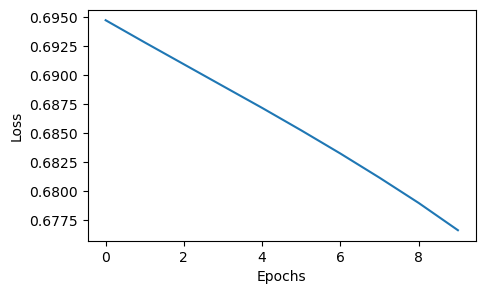

In [57]:
plt.figure(figsize=(5,3))
plt.plot(range(epochs), loss_curve)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [58]:
evaluate_model(graph, model, device)

Train AUC: 0.9763513015874961, F1: 0.6884612595507914, Precision: 0.5249263619273572, Recall: 1.0
Test AUC: 0.9764673486967013, F1: 0.6883502654058424, Precision: 0.5247973199329983, Recall: 1.0


In [63]:
def get_top_hits_for_disease(model, disease_index, graph, top_k=50):
    model.eval()
    with torch.no_grad():
        out = model(graph.x_dict, graph.edge_index_dict)
    disease_feature = out['disease'][disease_index]
    drug_scores = torch.matmul(out['drug'], disease_feature)
    top_drugs = torch.topk(drug_scores, k=top_k).indices
    return top_drugs
    
top_drugs = get_top_hits_for_disease(model, disease_index=1446, graph=graph, top_k=20).numpy()

file = "../data/processed_step2/map_drug.pkl"
with open(file, 'rb') as f:
    drug_map = pickle.load(f)
    
inverse_drug_map = {}
for key in drug_map:
    value = drug_map[key]
    inverse_drug_map[value] = key

top_drug_names = []
for drug in top_drugs:
    top_drug_names.append(inverse_drug_map[drug])
print(top_drug_names)
# print(top_drugs)

['DB00939', 'DB01262', 'DB00847', 'DB00184', 'DB00602', 'DB00641', 'DB01182', 'DB03255', 'DB00400', 'DB00472', 'DB00490', 'DB04468', 'DB00593', 'DB00635', 'DB01254', 'DB04209', 'DB00262', 'DB00780', 'DB00284', 'DB00945']
